In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *

np.random.seed(0)

#
#
noise_percent = 500
#
#

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Translated into Python from AK Kassam and LN Trefethen, July 2002
from scipy.fftpack import fft, ifft, fftfreq

# Spatial grid and IC
n = 256
x = 32*np.pi*np.linspace(0,1,n+1)[:-1]
u = np.cos(x/16)*(1+np.sin(x/16))
v = fft(u)

# Precompute various ETDRK4 scalar quantities:
h = 0.01
k = np.array(np.concatenate([np.arange(n/2),np.array([0]),-np.arange(1,n/2)[::-1]]))/16
L = (k**2-k**4)
E = np.exp(h*L)
E2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(M)+0.5)/M)
LR = h*np.vstack([L for _ in range(M)]) + np.hstack([np.reshape(r, (M,1)) for _ in range(n)])
LR = LR.T
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis = 1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis = 1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis = 1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis = 1))

uu = [u]; tt= [0]
tmax = 150; jmax = int(tmax/h); jplt=floor(tmax/250/h)
g = -0.5*1j*k

for j in range(1,jmax+1):
    
    t = j*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = E2*v+Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = E2*v+Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = E2*a+Q*(2*Nb-Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = E*v+Nv*f1+2*(Na+Nb)*f2+Nc*f3
    
    if j%jplt == 0:
        
        u = np.real(ifft(v))
        uu.append(u)
        tt.append(t)
        
X = np.stack(uu).T; t = np.array(tt); dx = x[1]-x[0]
n,m = X.shape

In [3]:
n = X.shape[0]
noise_level = 0.01*noise_percent*np.var(X)
measurement_noise_gaussian = np.sqrt(noise_level)*np.random.randn(*X.shape)

# Try red noise
r = 0.75
measurement_noise = np.zeros_like(measurement_noise_gaussian)
measurement_noise[:,0] = measurement_noise_gaussian[:,0]
for j in range(1,m): measurement_noise[:,j] = r*measurement_noise[:,j-1] + \
                                              (1-r**2)**0.5*measurement_noise_gaussian[:,j]

        
Y = X + measurement_noise

print("Noise/Signal:", np.linalg.norm(measurement_noise) / np.linalg.norm(X))

Noise/Signal: 2.225240304986944


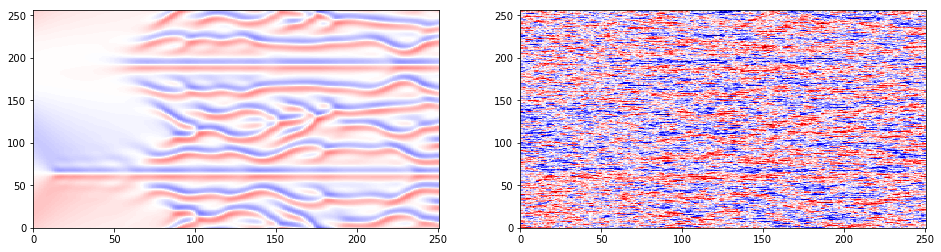

In [4]:
figure(figsize = (16,4))

vmin = np.min(np.stack([X,Y]))
vmax = np.max(np.stack([X,Y]))

subplot(1,2,1); pcolor(X[:,:], vmin=vmin, vmax=vmax, cmap = 'seismic')
subplot(1,2,2); pcolor(Y[:,:], vmin=vmin, vmax=vmax, cmap = 'seismic')

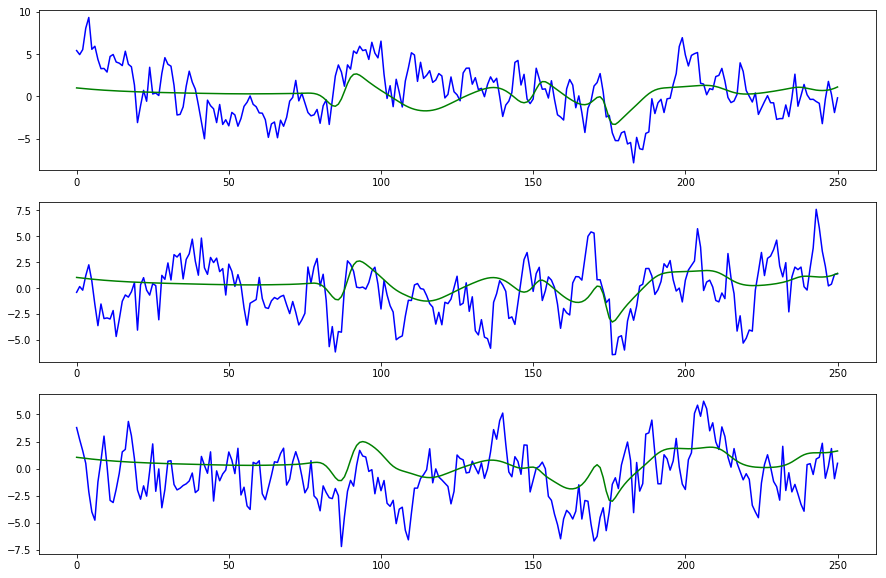

In [5]:
figure(figsize = (15,10))
subplot(3,1,1); plot(Y[0,:], 'b')
subplot(3,1,2); plot(Y[1,:], 'b')
subplot(3,1,3); plot(Y[2,:], 'b')

subplot(3,1,1); plot(X[0,:], 'g')
subplot(3,1,2); plot(X[1,:], 'g')
subplot(3,1,3); plot(X[2,:], 'g')

In [6]:
def tf_shift(x, s):
    
    n,m = tf.shape(x).eval()
        
    if s == 0: return x
    elif s>0: return tf.concat([tf.slice(x,[s,0],[n-s,m]),tf.slice(x,[0,0],[s,m])], axis = 0)
    else: return tf.concat([tf.slice(x,[n+s,0],[-s,m]),tf.slice(x,[0,0],[n+s,m])], axis = 0)
        
def tf_KS(x):
        
    return -x*(tf_shift(x,1)-tf_shift(x,-1))/(2*dx) - (tf_shift(x,1)+tf_shift(x,-1)-2*x)/dx**2- \
            (tf_shift(x,2)-4*tf_shift(x,1)+6*x-4*tf_shift(x,-1)+tf_shift(x,-2))/dx**4

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

optimizer, X_hat_tf, cost = create_computational_graph(Y, t, tf_KS, method = 'Gauss3', reg_derivative=1e-5)

init = tf.global_variables_initializer()
sess.run(init)

In [8]:
cost[0].eval()

14502448000.0

In [9]:
optimizer.minimize(sess)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.985457
  Number of iterations: 35545
  Number of functions evaluations: 35762


In [10]:
X_hat = X_hat_tf.eval()

/home/samuel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


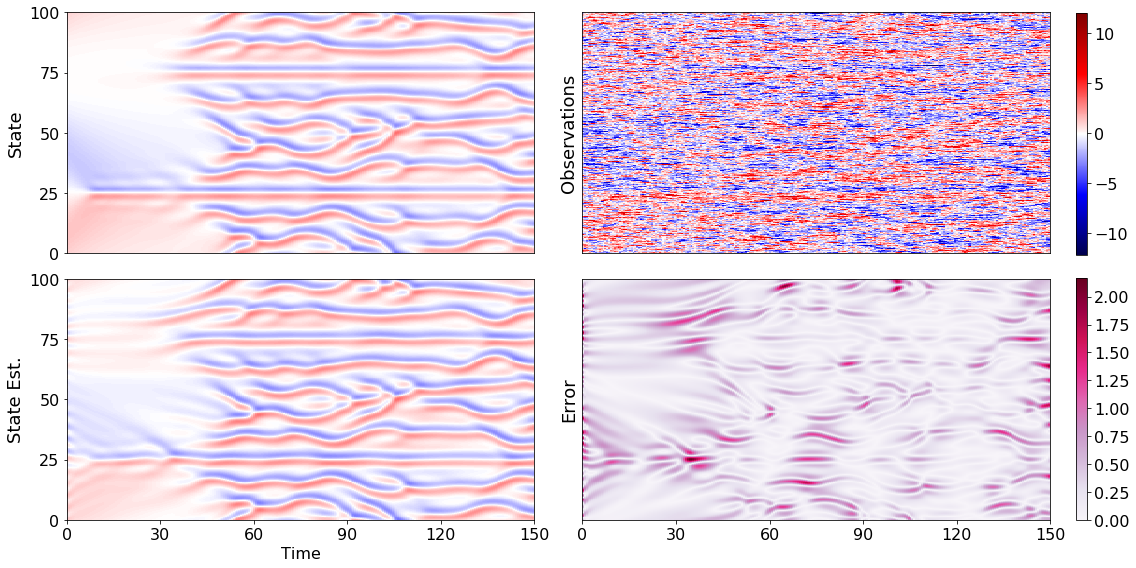

In [11]:
fig = figure(figsize = (15,8))

vmax_err = np.max(abs(X-X_hat))
vmax_sol = np.max([Y, X, X_hat])
vmin_sol = np.min([Y, X, X_hat])

cmap = 'seismic' 
err_cmap = 'PuRd'
label_fs = 16

xx,tt = meshgrid(t,x)

Yticks = [0,25,50,75,100]
Xticks = [0,30,60,90,120,150]

# State
subplot(2,2,1)
obs_plot = pcolor(xx, tt, X, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks(Yticks, fontsize = label_fs)
ylim([0,x[-1]])
xlim([0,t[-1]])
ylabel(r'State', fontsize = label_fs+2)

# Observations
subplot(2,2,2)
pcolor(xx, tt, Y, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
yticks([], fontsize = label_fs)
xticks([])
ylim([0,x[-1]])
xlim([0,t[-1]])
ylabel(r'Observations', fontsize = label_fs+2)

# Implicit denoising state estimate
subplot(2,2,3)
pcolor(xx, tt, X_hat, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks(Xticks, fontsize = label_fs)
yticks(Yticks, fontsize = label_fs)
ylim([0,x[-1]])
xlim([0,t[-1]])
ylabel(r'State Est.', fontsize = label_fs+2)
xlabel('Time', fontsize = label_fs)

# Error
subplot(2,2,4)
err_plot = pcolor(xx, tt, abs(X-X_hat), cmap = err_cmap, vmin = 0, vmax = vmax_err)
yticks([], fontsize = label_fs)
xticks(Xticks, fontsize = label_fs)
ylim([0,x[-1]])
xlim([0,t[-1]])
ylabel(r'Error', fontsize = label_fs+2)

position=fig.add_axes([1.,0.09,0.01,0.42])
cb = fig.colorbar(err_plot,cax=position)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=label_fs)

position2=fig.add_axes([1.,0.55,0.01,0.42])
cb2 = fig.colorbar(obs_plot,cax=position2) 
cb2.ax.set_yticklabels(cb2.ax.get_yticklabels(), fontsize=label_fs)

tight_layout()

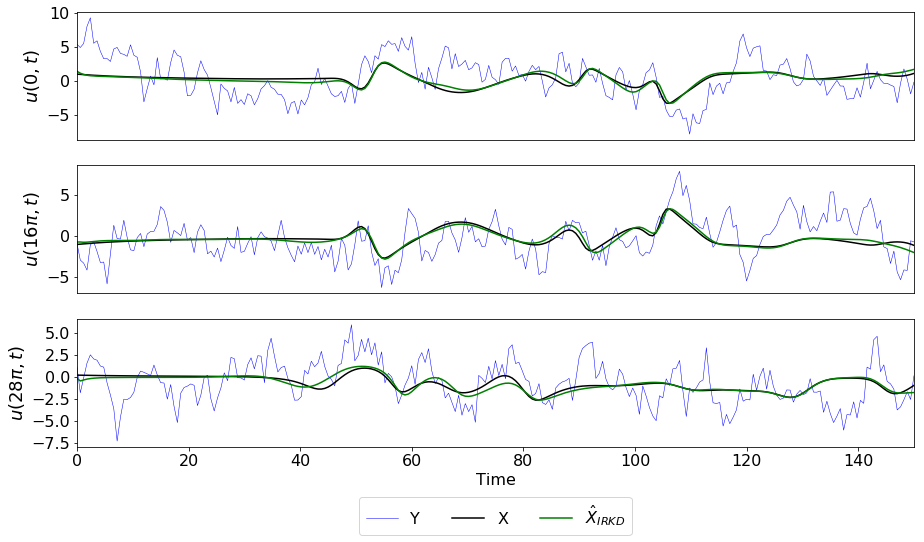

In [12]:
figure(figsize = (15,8))

start = 0
end = m

index_1 = 0
index_2 = 128
index_3 = 224

subplot(3,1,1); plot(t[start:end]-t[start], Y[index_1,start:end], 'b', linewidth = 0.5)
subplot(3,1,2); plot(t[start:end]-t[start], Y[index_2,start:end], 'b', linewidth = 0.5)
subplot(3,1,3); plot(t[start:end]-t[start], Y[index_3,start:end], 'b', label = 'Y', linewidth = 0.5)

subplot(3,1,1); plot(t[start:end]-t[start], X[index_1,start:end], 'k')
subplot(3,1,2); plot(t[start:end]-t[start], X[index_2,start:end], 'k')
subplot(3,1,3); plot(t[start:end]-t[start], X[index_3,start:end], 'k', label = 'X')

subplot(3,1,1); plot(t[start:end]-t[start], X_hat[index_1,start:end], 'g')
subplot(3,1,2); plot(t[start:end]-t[start], X_hat[index_2,start:end], 'g')
subplot(3,1,3); plot(t[start:end]-t[start], X_hat[index_3,start:end], 'g', label = r'$\hat{X}_{IRKD}$')

subplot(3,1,1)
yticks(fontsize = 16)
ylabel(r'$u(0,t)$', fontsize = 18)
xticks([])
xlim([0,150])

subplot(3,1,2)
yticks(fontsize = 16)
ylabel(r'$u(16\pi,t)$', fontsize = 18)
xticks([])
xlim([0,150])

subplot(3,1,3)
yticks(fontsize = 16)
ylabel(r'$u(28\pi,t)$', fontsize = 18)
xticks(fontsize = 16)
xlabel('Time', fontsize = 16)
xlim([0,150])

legend(fontsize = 16, loc='lower center', bbox_to_anchor=(0.5, -0.75),
          ncol=3)